# Example working with OSM data and tc and river flood with climate change 

In [2]:
import matplotlib.pyplot as plt
import shapely
import contextily as ctx
from pathlib import Path
from climada.util.api_client import Client
from climada.engine import Impact
from climada_petals.entity.exposures.openstreetmap.osm_dataloader import OSMRaw, OSMApiQuery, OSMFileQuery
from climada import CONFIG
from climada_petals.entity.exposures.openstreetmap.osm_dataloader import DICT_CIS_OSM

DATA_DIR = CONFIG.exposures.openstreetmap.local_data.dir()

In [3]:
gdf_health = HNDFileQuery.retrieve_cis('healthcare')

extract points: 
extract multipol
/Users/szelie/python_projects/climada_petals/climada_petals/entity/exposures/openstreetmap/osm_dataloader.py:420: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(


In [135]:
from shapely import wkt
import numpy as np

health_df = pd.read_excel('locations_preprocessed.xlsx')
health_df = health_df[['name','geometry','Level']]
health_df.rename(columns={'Level':'impf_id'})
health_df['geometry'] = health_df['geometry'].apply(wkt.loads)
health_df = gpd.GeoDataFrame(
    health_df, geometry=health_df.geometry)

health_exposure = Exposures(health_df)
health_exposure.gdf['longitude'] = health_exposure.gdf['geometry'].centroid.x
health_exposure.gdf['latitude'] = health_exposure.gdf['geometry'].centroid.y
health_exposure.set_crs('epsg:4326')



/var/folders/f5/lms0b90j1kx7kk4v552qkjqw0000gp/T/ipykernel_12948/2644954037.py:12: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  health_exposure.gdf['longitude'] = health_exposure.gdf['geometry'].centroid.x
/var/folders/f5/lms0b90j1kx7kk4v552qkjqw0000gp/T/ipykernel_12948/2644954037.py:13: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  health_exposure.gdf['latitude'] = health_exposure.gdf['geometry'].centroid.y


In [127]:
health_exposure.gdf['impf_TC'] = 1

<GeoAxesSubplot:>

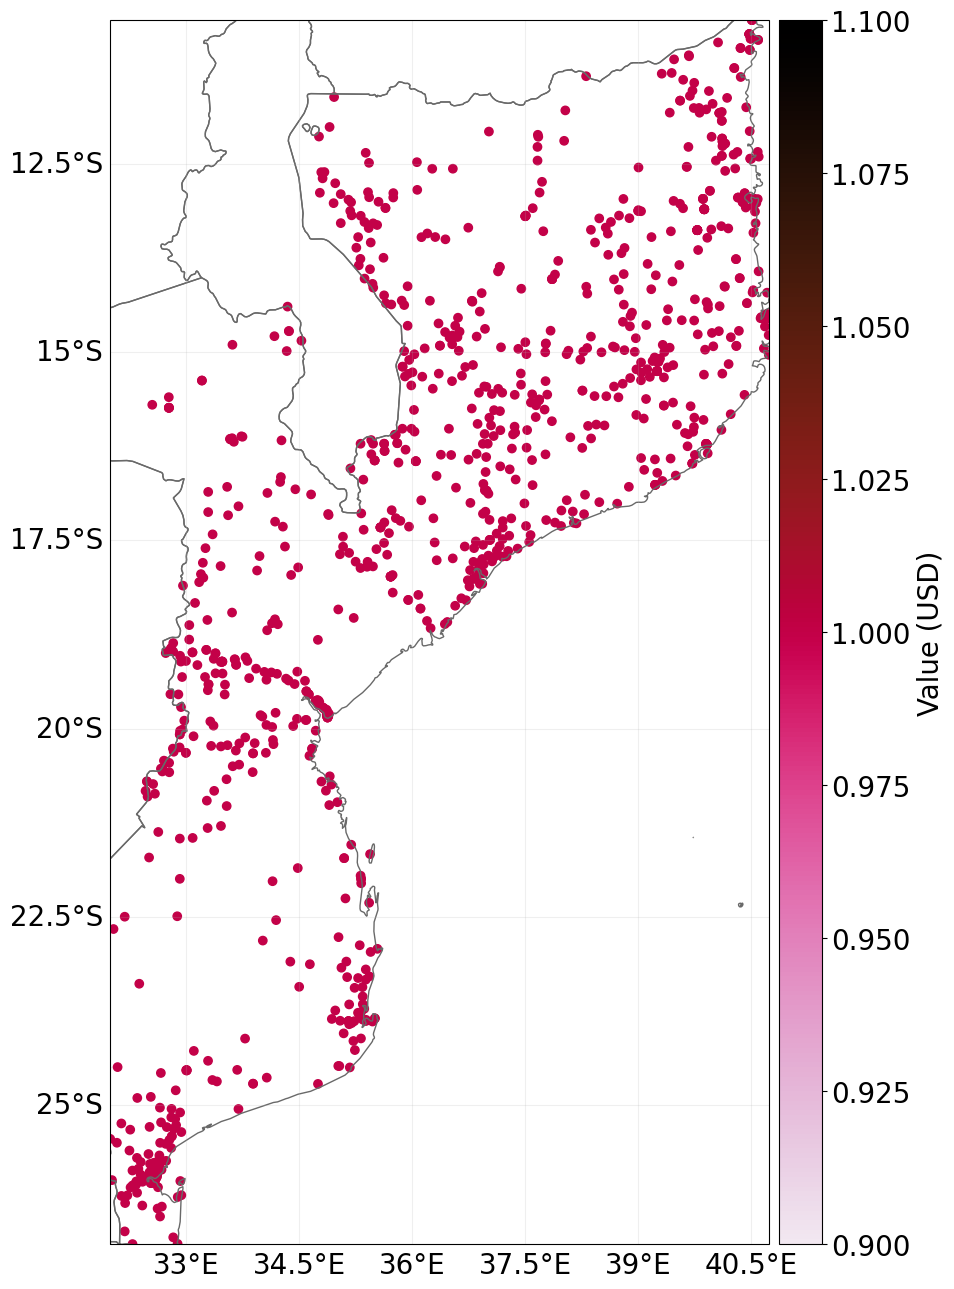

In [65]:
health_exposure.plot_scatter(pop_name=False)

## TC

In [66]:
## getting TC from the API, based on the STORM model
from climada.util.api_client import Client

client = Client()
tc_present=client.get_hazard("tropical_cyclone", properties={'country_iso3alpha':'MOZ','track_model':'STORM', 'climate_scenario': 'historical'}, status='preliminary')
tc_future=client.get_hazard("tropical_cyclone", properties={'country_iso3alpha':'MOZ','track_model':'STORM','gcm':'CNRM-CM6-1-HR'}, status='preliminary')
#status will change to active in the future, so modify that in the query if it is not working

https://climada.ethz.ch/data-api/v1/dataset	climate_scenario=historical	country_iso3alpha=MOZ	data_type=tropical_cyclone	limit=100000	name=None	status=preliminary	track_model=STORM	version=None
https://climada.ethz.ch/data-api/v1/dataset	country_iso3alpha=MOZ	data_type=tropical_cyclone	gcm=CNRM-CM6-1-HR	limit=100000	name=None	status=preliminary	track_model=STORM	version=None


In [102]:
import datetime
np.max(tc_present.intensity)

83.41629305880228

In [92]:
impf_world_bank = ImpactFuncSet()

In [120]:
ImpF = ImpactFunc()
ImpF.id = 1
ImpF.name = 'impf_TC'
ImpF.intensity_unit = 'm/s'
ImpF.haz_type = 'TC'
ImpF.intensity = np.array([12,18,20,40,50,60,70,90]) # intensity range over which the ImpF is defined
ImpF.mdd =np.array([0,0.03,0.3,0.5,0.6,0.61,0.61,0.61])
ImpF.paa = np.ones(ImpF.intensity.shape)
impf_TC = ImpactFuncSet()
impf_TC.append(ImpF)

In [97]:
impf_tc = ImpactFuncSet()
impf_tc.intensity = np.arange(0,100)
impf_tc.m

In [117]:
ImpF.check()

In [124]:
impf_TC.get_func('TC',1)

In [130]:
# impact calculation,"old way", there is a better way to do it if you are on develop, but this works anyways.
# you can have a look at the tutorials if you want to update it
health_exposure.gdf['value'] = 1
imp_hospitals_present = Impact()
imp_hospitals_present.calc(health_exposure, impf_TC, tc_present, save_mat=True)


2022-11-10 17:33:23,370 - climada.engine.impact - WARNING - The use of Impact().calc() is deprecated. Use ImpactCalc().impact() instead.


In [131]:
imp_hospitals_future = Impact()
imp_hospitals_future.calc(health_exposure, impf_TC, tc_future, save_mat=True)



2022-11-10 17:33:31,665 - climada.engine.impact - WARNING - The use of Impact().calc() is deprecated. Use ImpactCalc().impact() instead.


<GeoAxesSubplot:title={'center':'Expected annual impact'}>

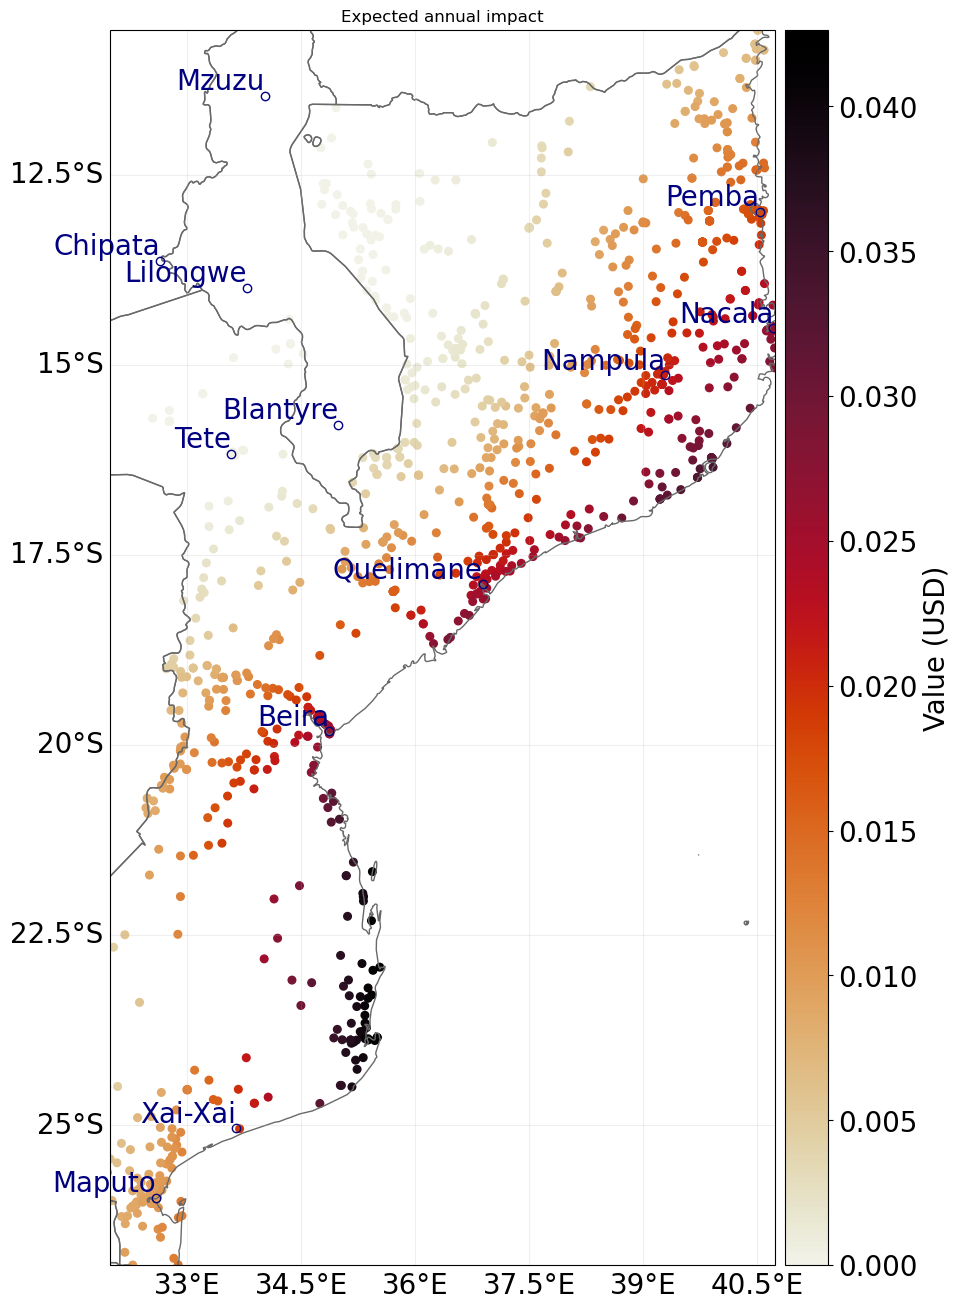

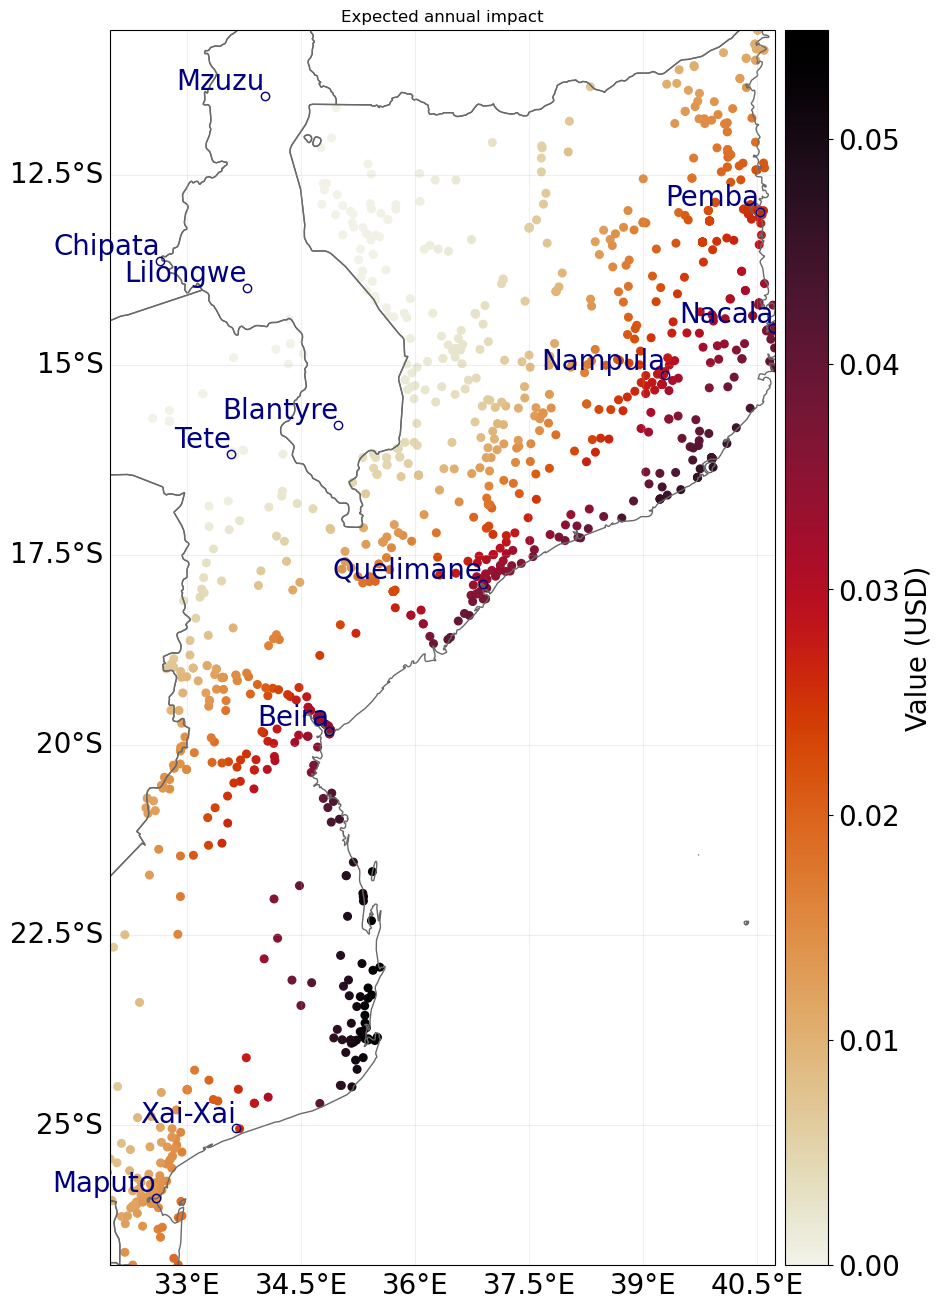

In [136]:
imp_hospitals_present.plot_scatter_eai_exposure(s=30)
imp_hospitals_future.plot_scatter_eai_exposure(s=30)

In [152]:
import copy
change_imp = copy.deepcopy(imp_hospitals_present)
change_imp.eai_exp = 100*(imp_hospitals_future.eai_exp - imp_hospitals_present.eai_exp)/imp_hospitals_present.eai_exp

/var/folders/f5/lms0b90j1kx7kk4v552qkjqw0000gp/T/ipykernel_12948/2550076445.py:3: RuntimeWarning: divide by zero encountered in divide
  change_imp.eai_exp = 100*(imp_hospitals_future.eai_exp - imp_hospitals_present.eai_exp)/imp_hospitals_present.eai_exp
/var/folders/f5/lms0b90j1kx7kk4v552qkjqw0000gp/T/ipykernel_12948/2550076445.py:3: RuntimeWarning: invalid value encountered in divide
  change_imp.eai_exp = 100*(imp_hospitals_future.eai_exp - imp_hospitals_present.eai_exp)/imp_hospitals_present.eai_exp


<GeoAxesSubplot:title={'center':'Expected annual impact'}>

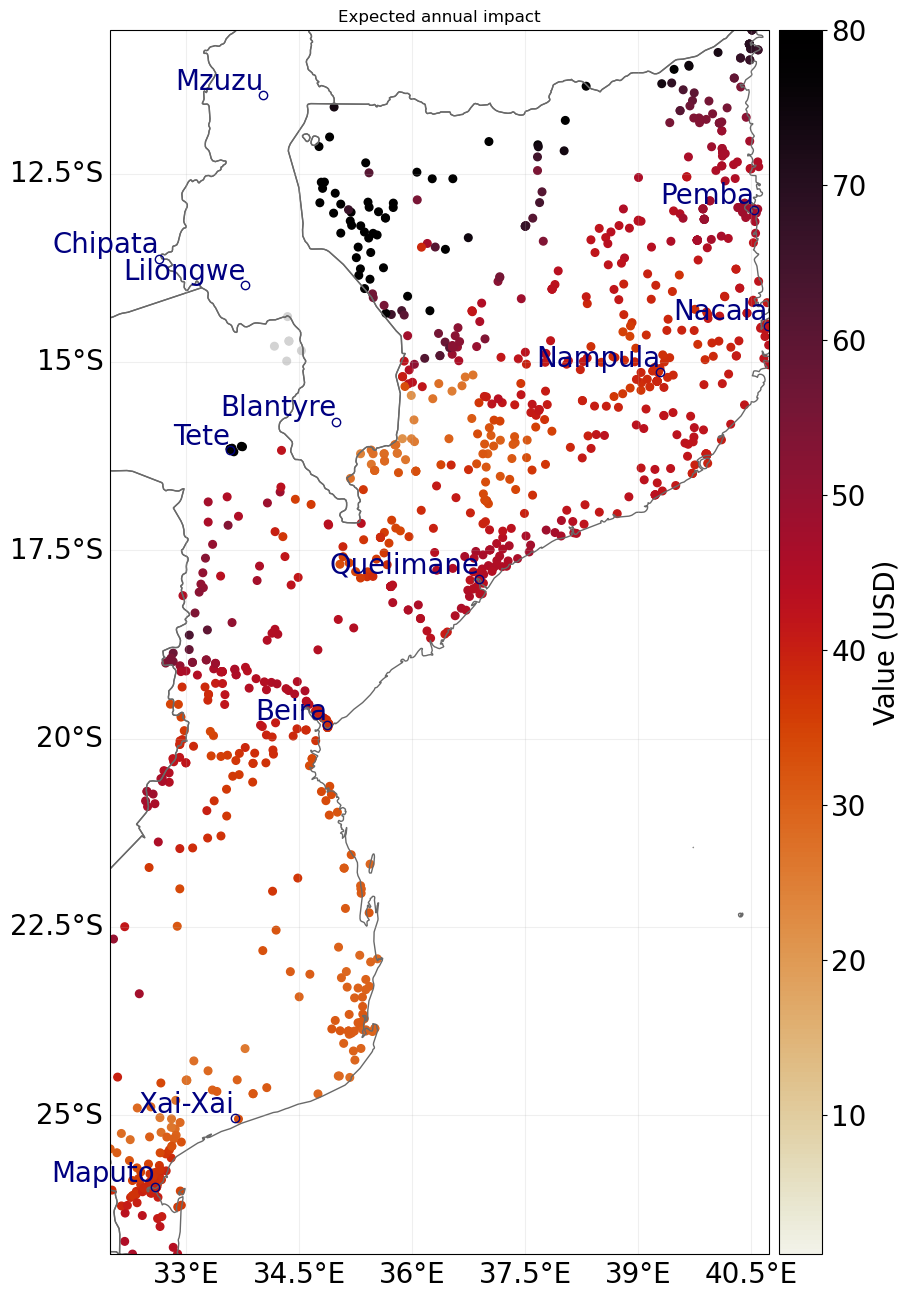

In [156]:
change_imp.plot_scatter_eai_exposure(s=30, vmax=80,vmin=1)

